<a href="https://colab.research.google.com/github/thiyagi9/PythonPractises/blob/main/BBS21_Spotify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Musical Classifiers

In this notebook we build classifiers to predict the *gender* of a *song* using attributes computed from the *Spotify* API.


<table align='left'>
<tr>
<td><img src='http://jricardon.github.io/spambase/spotify.png' width='800'/> </td>
</tr>
</table>


# Data

We will use data from the *Spotify Tracks* database available at *kaggle.com*, an online community of data scientists and machine learning practitioners. 

> *https://www.kaggle.com/zaheenhamidani/ultimate-spotify-tracks-db*

It contains information of 232,725 tracks classified into 26 non-exclusive genres. Different audio features have been extracted for each track using the Spotify Tracks API 

> *https://developer.spotify.com/documentation/web-api/reference/#endpoint-get-several-audio-features*

These musical features are: danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo. Besides we have: the track_name, the artist_name, the track_id and the track popularity.
The first may be encoded using text representation techniques but if you are not familiar with them, you can exclude these attributes from the analysis. Of course, the track_id should not be used as a predictor (why?).





# Data Download

You can directly download the data from *kaggle.com* and upload the csv file to the platform you normally use to run this notebook (e.g. Anaconda + BBS virtual machine). 

As I typically run the notebook on Google Colab, I use to mount my Google Drive on the virtual machine. The code below shows how to do that. If you have a Google Drive account you can proceed the same way, modifying of course the name of the folder where have stored the file. 



In [ ]:
print("Mounting your Google Drive ...")

from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive',force_remount=True)
 
path = "/content/drive/My Drive/BBS-2021/"#You have to update this path

name = 'SpotifyTracksDB.csv'


Mounting your Google Drive ...
Mounted at /content/drive


The code below reads the csv file (comma separated values) and creates a pandas dataframe with the info we have about the tracks. There was a problem with the class "Children’s Music" that existed in two variants: "Children’s Music" and "Children's Music".   



In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

data = pd.read_csv(path+name)
data = data.dropna()
print(data.columns)

genres = np.unique([str(item) for item in data['genre'].values])
print("Genre (Raw)\n", genres)
print("")
data.loc[data['genre']=="Children’s Music", 'genre'] = "Children's Music"
genres = np.unique([str(item) for item in data['genre'].values])
print("Genre (Fixed)\n", genres)
print("")

full_data = data.copy()


Index(['genre', 'artist_name', 'track_name', 'track_id', 'popularity',
       'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence'],
      dtype='object')
Genre (Raw)
 ['A Capella' 'Alternative' 'Anime' 'Blues' "Children's Music"
 'Children’s Music' 'Classical' 'Comedy' 'Country' 'Dance' 'Electronic'
 'Folk' 'Hip-Hop' 'Indie' 'Jazz' 'Movie' 'Opera' 'Pop' 'R&B' 'Rap'
 'Reggae' 'Reggaeton' 'Rock' 'Ska' 'Soul' 'Soundtrack' 'World']

Genre (Fixed)
 ['A Capella' 'Alternative' 'Anime' 'Blues' "Children's Music" 'Classical'
 'Comedy' 'Country' 'Dance' 'Electronic' 'Folk' 'Hip-Hop' 'Indie' 'Jazz'
 'Movie' 'Opera' 'Pop' 'R&B' 'Rap' 'Reggae' 'Reggaeton' 'Rock' 'Ska'
 'Soul' 'Soundtrack' 'World']



# Basic Exploratory Data Analysis

## Songs by Genre

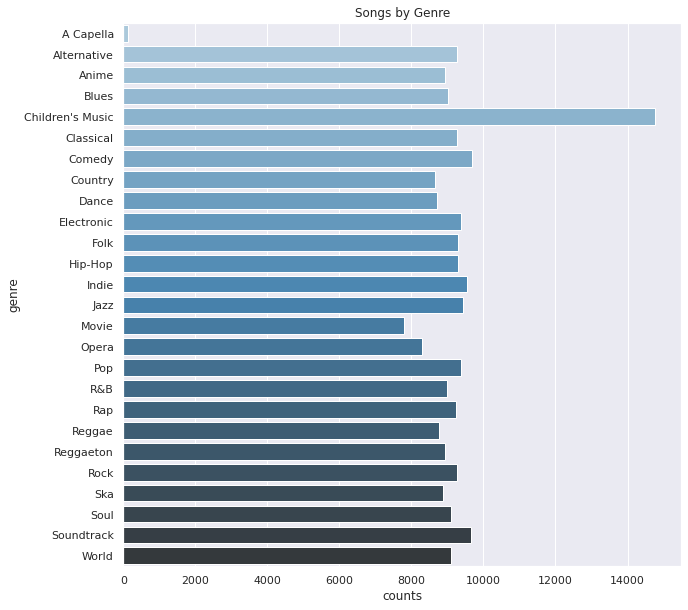

In [ ]:
gr = data.groupby(['genre']).size().reset_index(name='counts')
fig, ax = plt.subplots(figsize=(10,10),nrows=1)
sns.barplot(data=gr, y='genre', x='counts', palette="Blues_d",ax=ax)
ax.set_title('Songs by Genre')
plt.show()

## Popular Artists

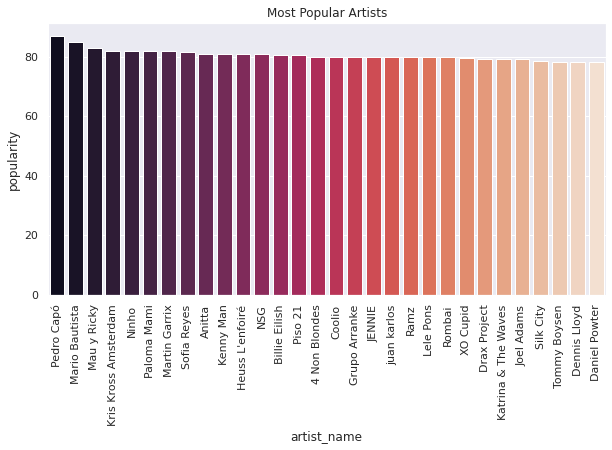

In [ ]:
gr = data.groupby(['artist_name'])['popularity'].mean().sort_values(ascending=False)
gr = gr.reset_index(name='popularity').head(30)
fig, ax = plt.subplots(figsize=(10,5),nrows=1)
p = sns.barplot(data=gr, x='artist_name', y='popularity', palette="rocket",ax=ax)
plt.setp(p.get_xticklabels(), rotation=90)
ax.set_title('Most Popular Artists')
plt.show()

print("")

## Some Tracks

In [ ]:
indices = data.index[(data['genre'] == 'Rock')].tolist()
#indices = data.index[(data['genre'] == 'Pop') & (data['artist_name'] == 'Ed Sheeran')].tolist()
#indices = data.index[(data['genre'] == 'Rock') & (data['artist_name'] == 'Queen')].tolist()
#indices = data.index[(data['genre'] == 'Jazz') & (data['track_name'] == 'The Girl From Ipanema')].tolist()
test_idx = np.random.choice(indices, 1)

print("\nSong: ", data.loc[test_idx]['track_name'].values[0])
print("Artist: ", data.loc[test_idx]['artist_name'].values[0])
print("Ground Truth:",data.loc[test_idx]['genre'].values[0])


Song:  Nice to Know You
Artist:  Incubus
Ground Truth: Rock


## Select a Subset of Genres

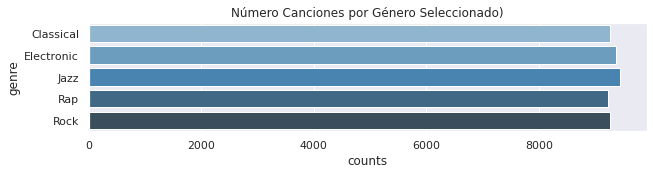

In [ ]:
# select 2
#selected_genres = ['Classical','Electronic'] 

# select 5
selected_genres = ['Classical','Electronic','Jazz','Rock','Rap']

not_selected_genres = [genre for genre in genres if genre not in selected_genres]
genres = selected_genres

data = full_data[full_data['genre'].isin(selected_genres)]

gr = data.groupby(['genre']).size().reset_index(name='counts')
fig, ax = plt.subplots(figsize=(10,2),nrows=1)
sns.barplot(data=gr, y='genre', x='counts', palette="Blues_d",ax=ax)
ax.set_title('Número Canciones por Género Seleccionado)')
plt.show()


genre_to_number = {label: i for i, label in enumerate(set(genres), 0)}
number_to_genre = {i: label for i, label in enumerate(set(genres), 0)}

for genre in genres:
  data.loc[data['genre'] == genre, 'class'] = genre_to_number[genre]


## Distribution of the Attributes

Index(['genre', 'artist_name', 'track_name', 'track_id', 'popularity',
       'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence', 'class'],
      dtype='object')
10


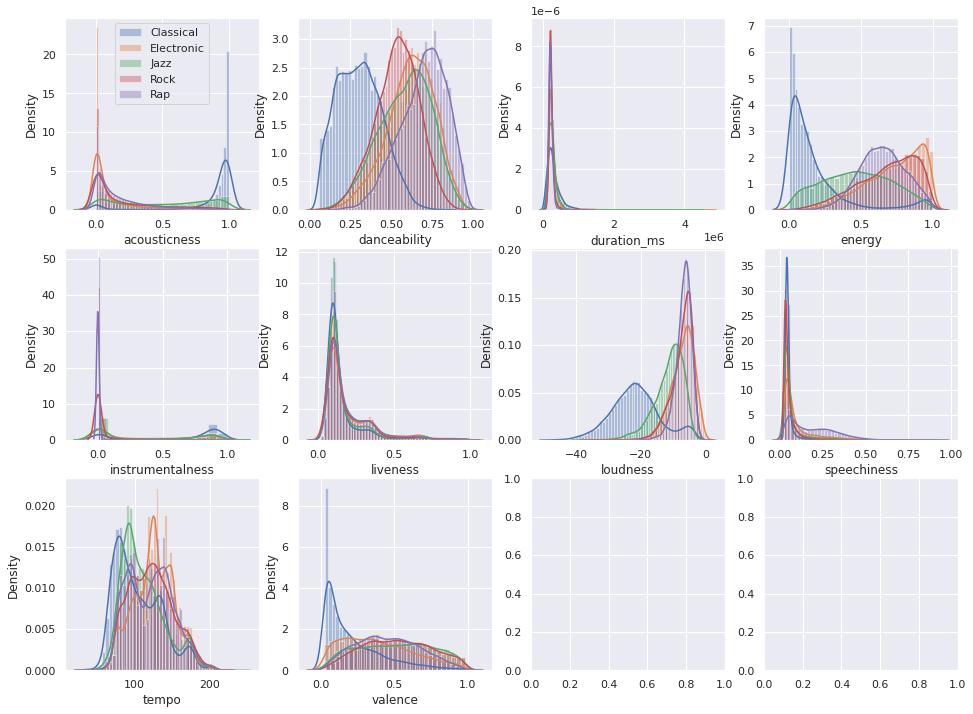

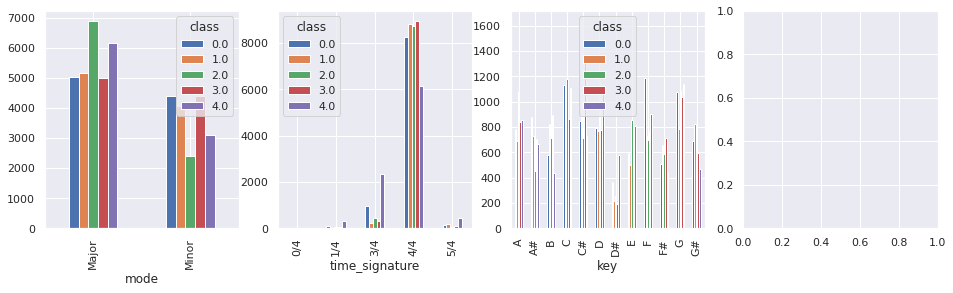

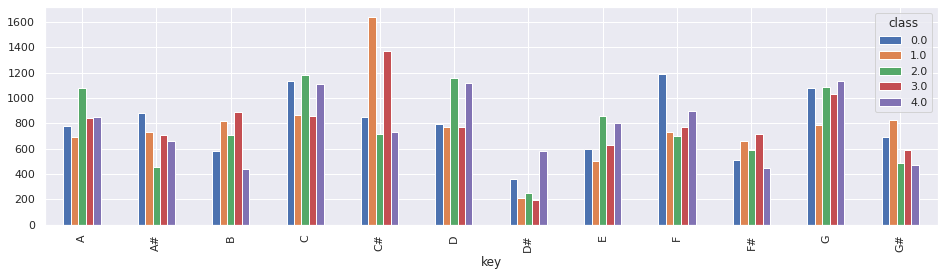

In [ ]:
#playlist_name no
print(data.columns)

cont_predictors_names = ['acousticness','danceability','duration_ms','energy','instrumentalness','liveness','loudness','speechiness','tempo','valence']
cat_predictors = ['mode','time_signature','key']
other_predictors = ['genre','artist_name','track_name','track_id']

#major = 1
#minor = 0
#(1,0,0,0,0,0,0,0,0,0,0,0,0)
print(len(cont_predictors_names))

#dummies = pd.get_dummies(df['Category'])

fig, axes = plt.subplots(figsize=(16,12), nrows=3, ncols=4)
for i, column in enumerate(cont_predictors_names):
    for genre in genres:
      target = data.loc[data['genre'] == genre]
      sns.distplot(target[column], hist=True, rug=False, kde=True, ax=axes[i//4,i%4],label=genre)
      if i==0:
        axes[0,0].legend()

plt.show()

fig, axes = plt.subplots(figsize=(16,4), nrows=1, ncols=4)
for i, column in enumerate(cat_predictors):
  df_gb = data.groupby([column, 'class']).size().unstack(level=1)
  df_gb.plot(kind = 'bar',ax=axes[i%4])

plt.show()

fig, ax = plt.subplots(figsize=(16,4), nrows=1, ncols=1)
df_gb = data.groupby(['key', 'class']).size().unstack(level=1)
df_gb.plot(kind = 'bar',ax=ax)
plt.show()



## Boxplots

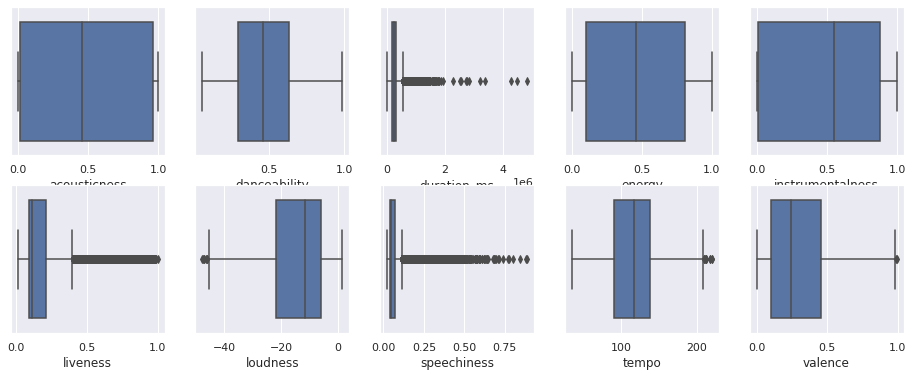

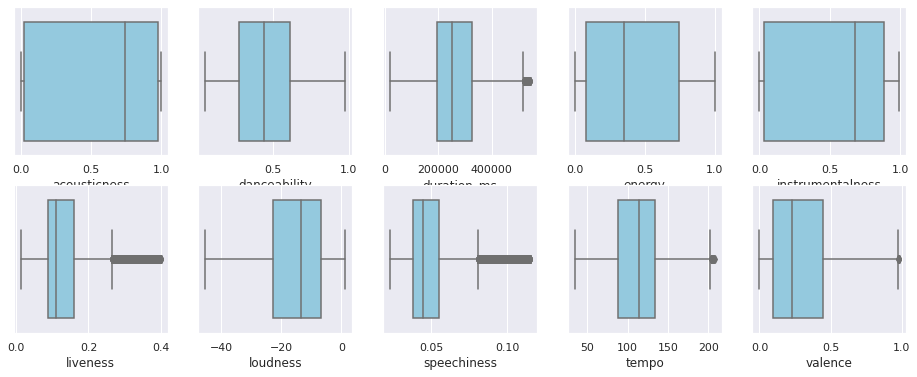

In [ ]:

fig, axes = plt.subplots(figsize=(16,6), nrows=2, ncols=5)
for i, column in enumerate(cont_predictors_names):
      sns.boxplot(x=data[column],ax=axes[i//5,i%5])

plt.show()

Q1 = data[cont_predictors_names].quantile(0.25)
Q3 = data[cont_predictors_names].quantile(0.75)
IQR = Q3 - Q1

filter = ((data[cont_predictors_names] < (Q1 - 1.5 * IQR)) | (data[cont_predictors_names] > (Q3 + 1.5 * IQR))).any(axis=1)

data_filtered = data[~filter].copy()
fig, axes = plt.subplots(figsize=(16,6), nrows=2, ncols=5)
for i, column in enumerate(cont_predictors_names):
      sns.boxplot(x=data_filtered[column],ax=axes[i//5,i%5],color="skyblue")

plt.show()

# Basic Pre-processing

In [ ]:
from sklearn.preprocessing import StandardScaler

cont_predictors_names = ['acousticness','danceability','duration_ms','energy','instrumentalness','liveness','loudness','speechiness','tempo','valence']
cat_predictors = ['mode','time_signature','key']
other_predictors = ['genre','artist_name','track_name','track_id']

cont_features = data[cont_predictors_names]
dummy_key = pd.get_dummies(data['key'],prefix='key')
dummy_mode = pd.get_dummies(data['mode'],prefix='mode')
dummy_signature = pd.get_dummies(data['time_signature'],prefix='time_sign')
binary_features = pd.concat([dummy_key,dummy_signature],axis=1)
binary_features = pd.concat([binary_features,dummy_mode],axis=1)
binary_predictors_names = binary_features.columns#names 

X = cont_features
y = data['class']
info = data[other_predictors]

print("X,y Shapes:", X.shape, y.shape)

from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=3,include_bias=False)
result = poly.fit_transform(cont_features.values)
cont_predictors_names = ['x'.join(['{}^{}'.format(pair[0],pair[1]) for pair in tuple if pair[1]!=0]) for tuple in [zip(cont_predictors_names,p) for p in poly.powers_]]
X = pd.DataFrame(result, columns = cont_predictors_names)
print("Binary Features Shapes:", binary_features.shape)

X = pd.concat([X.reset_index(drop=True),binary_features.reset_index(drop=True)],axis=1)

#X = pd.concat([X.reset_index(drop=True),text_features.reset_index(drop=True)],axis=1)
print("X,y Shapes:", X.shape, y.shape)
#scaler = StandardScaler()
#X[cont_predictors_names] = scaler.fit_transform(X[cont_predictors_names])

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, info_train, info_test = train_test_split(X, y, info, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val, info_train, info_val = train_test_split(X_train, y_train, info_train, test_size=0.2, random_state=0)

print("X,y Shapes:", X.shape, y.shape)
print("X,y Train Shapes:", X_train.shape, y_train.shape)
print("X,y Val Shapes:", X_val.shape, y_val.shape)
print("X,y Test Shapes:", X_test.shape, y_test.shape)

scaler = StandardScaler()
#Z = X-mu/sigma

X_train[cont_predictors_names] = scaler.fit_transform(X_train[cont_predictors_names])
X_val[cont_predictors_names] = scaler.transform(X_val[cont_predictors_names])
X_test[cont_predictors_names] = scaler.transform(X_test[cont_predictors_names])


X,y Shapes: (18633, 10) (18633,)
Binary Features Shapes: (18633, 18)
X,y Shapes: (18633, 303) (18633,)
X,y Shapes: (18633, 303) (18633,)
X,y Train Shapes: (11924, 303) (11924,)
X,y Val Shapes: (2982, 303) (2982,)
X,y Test Shapes: (3727, 303) (3727,)


# **Binary Models**

Please train and evaluate your binary models here. Execute all the previous cells before. In particular be sure you select the 2 genres/classes you want to classify in the section "Select a Subset of Genres"

**Activities:**

Train binary SVMs to classify the *Classical music* from *Electronic music*. In particular.

1.   Train a linear soft-margin SVM selecting the optimal value of the regularization parameter $C$.
2.   Train a non-linear SVM selecting a good kernel.
3.   Evaluate the classifiers giving an estimate of their prediction error.
4.   Assess the effect of the different audio attributes in the decisions of your model.



# **Support for Multiples Clases**

Here I provide some basic code to handle multiple classes. Execute all the previous in the sections "Data", "Data Download" and "Exploratory Data Analysis". In particular be sure you select the genres/classes you want to classify in the section "Select a Subset of Genres"

**Activities:**

Train SVMs to classify songs of the following 5 genres: Classical, Electronic,  Jazz,  Rock,  Rap.

1.   Use a linear soft-margin SVM selecting the optimal value of the regularization parameter $C$.
2.   Use a non-linear SVM selecting a good kernel.
3.   Evaluate the classifiers estimating the confusion matrix.
4.   Plot the weight of the different audio attributes for each binary sub-model. Discuss the results. 


### OVR (One versus the Rest)

N CLASSES = 2


Train/Val/Test Accuracy Multiclass (via OVR)

0.9643575981214357 0.9557344064386318 0.9519720955191844


[[0.93858696 0.06141304]
 [0.03497615 0.96502385]]


Precision (Macro, Micro) 0.9523810279087177 0.9519720955191844
Recall (Macro, Micro) 0.9518054019492639 0.9519720955191844
F1 (Macro, Micro) 0.9519415247117193 0.9519720955191844


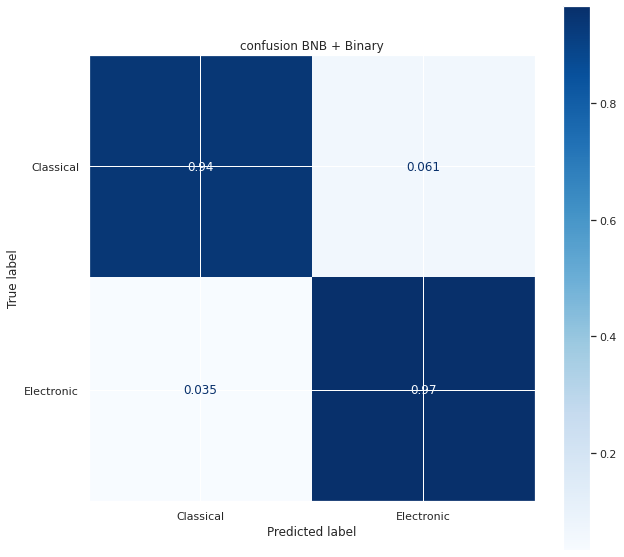

In [ ]:

from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_curve, auc, average_precision_score
from sklearn.metrics import f1_score, recall_score, precision_score

from sklearn.svm import SVC
base = SVC(kernel='linear', C=1)

n_classes = len(np.unique(y_train))
MAX_INT = np.iinfo(np.int32).max

print("N CLASSES = %d\n"%n_classes)

clf = OneVsRestClassifier(base).fit(X_train.values, y_train.values)

train_acc = clf.score(X_train.values, y_train.values)
val_acc = clf.score(X_val.values, y_val.values)
test_acc = clf.score(X_test.values, y_test.values)

print("\nTrain/Val/Test Accuracy Multiclass (via OVR)\n")
print(train_acc,val_acc,test_acc)

print("\n")
fig, ax = plt.subplots(figsize=(10, 10))
labels = [number_to_genre[clf.classes_[idx]] for idx in range(n_classes)]
disp = plot_confusion_matrix(clf, X_test.values,y_test.values, display_labels=labels, cmap=plt.cm.Blues,normalize='true',ax=ax)
disp.ax_.set_title("confusion BNB + Binary")

print(disp.confusion_matrix)


y_pred_test = clf.predict(X_test.values)
macro_prec = precision_score(y_test, y_pred_test, average='macro')
micro_prec = precision_score(y_test, y_pred_test, average='micro')

macro_recall = recall_score(y_test, y_pred_test, average='macro')
micro_recall = recall_score(y_test, y_pred_test, average='micro')

macro_f1 = f1_score(y_test, y_pred_test, average='macro')
micro_f1 = f1_score(y_test, y_pred_test, average='micro')

print("\n")
print("Precision (Macro, Micro)", macro_prec, micro_prec)
print("Recall (Macro, Micro)", macro_recall, micro_recall)
print("F1 (Macro, Micro)", macro_f1, micro_f1)



#### Feature Weights



Coefficients SVM + OVR



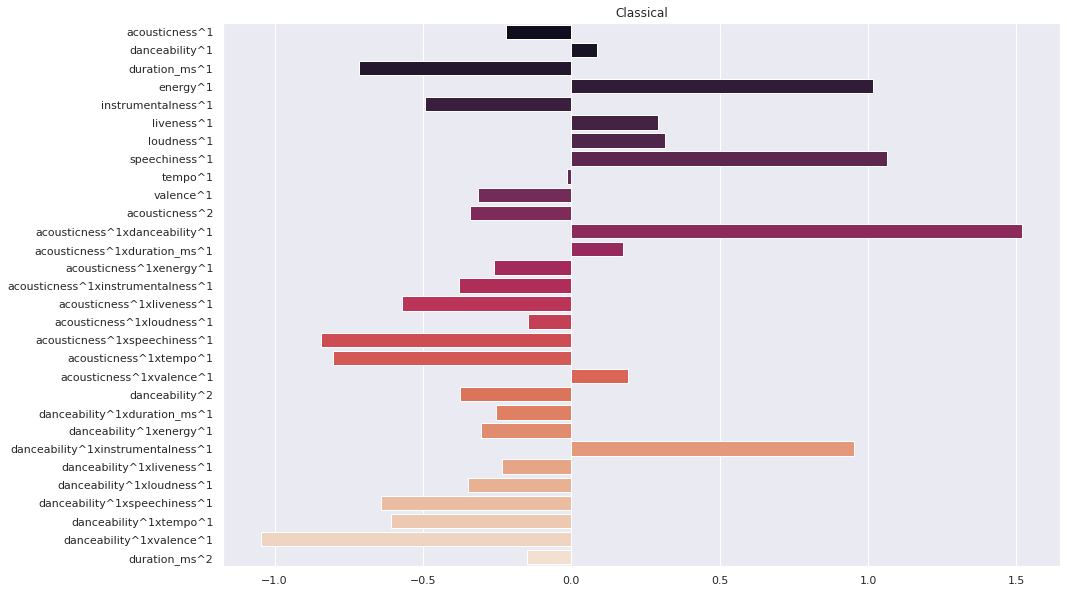

In [ ]:
from sklearn.svm import SVC

n_classes = len(np.unique(y_train))
MAX_INT = np.iinfo(np.int32).max

print("\nCoefficients SVM + OVR\n")

base = SVC(kernel='linear', C=1)
clf = OneVsRestClassifier(base).fit(X_train.values, y_train.values)

fig, axes = plt.subplots(figsize=(15,10),nrows=1,ncols=len(clf.estimators_),sharex=False,sharey=True,squeeze=False)

for idx,estimator in enumerate(clf.estimators_):
  w = estimator.coef_
  b = estimator.intercept_

  max_feat = min(len(w[0,:]),30)

  sns.barplot(y=np.arange(max_feat),x=w[0,:max_feat],palette="rocket",ax=axes[0,idx%5],orient="h")
  axes[0,idx%5].set_yticklabels(X.columns[:max_feat])
  axes[0,idx%5].set_title('%s'%number_to_genre[clf.classes_[idx]])
  
plt.show()


## OVO (One versus One)

In [ ]:
from sklearn.multiclass import OneVsOneClassifier
from sklearn.metrics import f1_score, recall_score, precision_score

n_classes = len(np.unique(y_train))
MAX_INT = np.iinfo(np.int32).max

base = SVC(kernel='linear', C=1)
clf = OneVsOneClassifier(base).fit(X_train.values, y_train.values)

train_acc = clf.score(X_train.values, y_train.values)
val_acc = clf.score(X_val.values, y_val.values)
test_acc = clf.score(X_test.values, y_test.values)

print(train_acc,val_acc,test_acc)
print(" ---- ")

print("\n")
fig, ax = plt.subplots(figsize=(10, 10))
labels = [number_to_genre[clf.classes_[idx]] for idx in range(n_classes)]
disp = plot_confusion_matrix(clf, X_test.values,y_test.values, display_labels=labels, cmap=plt.cm.Blues,normalize='true',ax=ax)
disp.ax_.set_title("confusion BNB + Binary")

#print(disp.confusion_matrix)

y_pred_test = clf.predict(X_test.values)
macro_prec = precision_score(y_test, y_pred_test, average='macro')
micro_prec = precision_score(y_test, y_pred_test, average='micro')

macro_recall = recall_score(y_test, y_pred_test, average='macro')
micro_recall = recall_score(y_test, y_pred_test, average='micro')

macro_f1 = f1_score(y_test, y_pred_test, average='macro')
micro_f1 = f1_score(y_test, y_pred_test, average='micro')

print("\n")
print("Precision (Macro, Micro)", macro_prec, micro_prec)
print("Recall (Macro, Micro)", macro_recall, micro_recall)
print("F1 (Macro, Micro)", macro_f1, micro_f1)

#### Feature Weights


Coefficients SVM + OVO

Par 0,1 - Classical vs Electronic




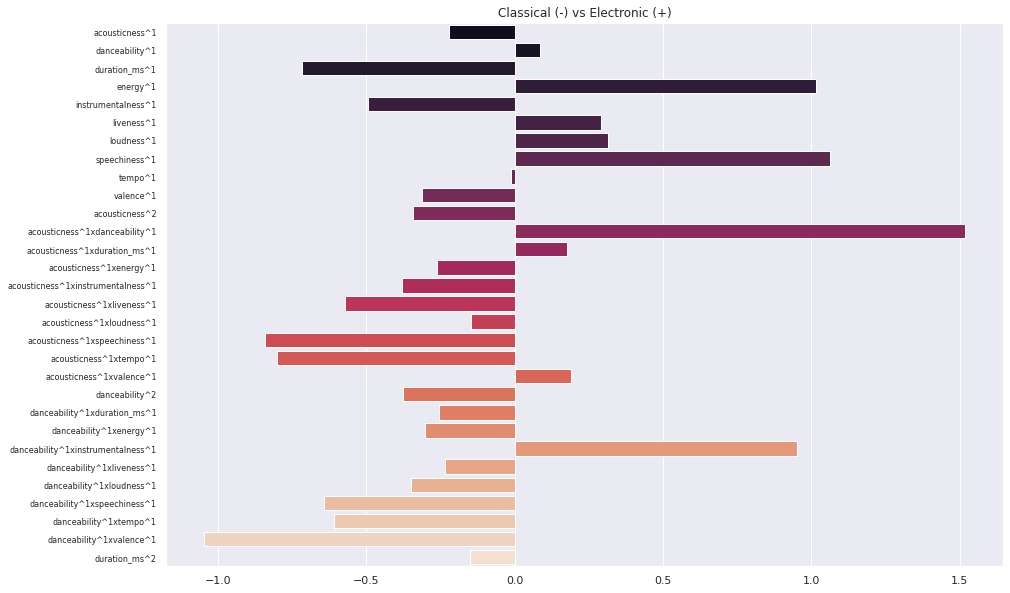

In [ ]:
n_classes = len(np.unique(y_train))
MAX_INT = np.iinfo(np.int32).max

print("\nCoefficients SVM + OVO\n")

base = SVC(kernel='linear', C=1)
clf = OneVsOneClassifier(base).fit(X_train.values, y_train.values)

fig, axes = plt.subplots(figsize=(15,10),nrows=1,ncols=1,sharex=False,sharey=True,squeeze=False)
if len(clf.classes_) > 2:
  fig, axes = plt.subplots(figsize=(15,10),nrows=2,ncols=5,sharex=False,sharey=True,squeeze=False)

counter = 0

for i in range(len(clf.classes_)):
  for j in range(i+1,len(clf.classes_)):
    estimator = clf.estimators_[counter]
    class1 = number_to_genre[clf.classes_[i]]
    class2 = number_to_genre[clf.classes_[j]]
    print("Par %d,%d - %s vs %s"%(i,j,class1,class2))
    w = estimator.coef_[0,:]
    b = estimator.intercept_

    max_feat = min(len(w),30)

    sns.barplot(y=np.arange(max_feat),x=w[:max_feat],palette="rocket",ax=axes[counter//5,counter%5],orient="h")
    axes[counter//5,counter%5].set_yticklabels(X.columns[:max_feat],fontsize=8)
    axes[counter//5,counter%5].set_title('%s (-) vs %s (+)'%(class1,class2))
  
    counter+=1

print("\n")
plt.show()